<a href="https://colab.research.google.com/github/erdemust/xulia/blob/master/Machine_Learning_and_Mathematics_Collaborators_or_Competitors%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
 import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Other
from mpl_toolkits.mplot3d import Axes3D

torch.manual_seed(0)
numpy.random.seed(0)


In [ ]:
#@title #### Helper Functions (Plotting)

def plot_data(x,y,z,ax=None):
    if ax is None: ax=plt.gca()
    if len(z.shape)>1: z = z.flatten()
        
    ax.scatter(x, y, z, c=z);

    ax.view_init(30, 135)
    ax.set_xlabel(r'Velocity $v$')
    ax.set_ylabel(r'Angle $\theta$')
    ax.set_zlabel(r'Distance', rotation=90);
    
def plot_model(X, Y, Z, ax=None):
    if ax is None: ax=plt.gca()
        
    ax.plot_surface(X, Y, Z, cmap=plt.cm.viridis);

    ax.view_init(30, 135)
    ax.set_xlabel(r'Velocity $v$')
    ax.set_ylabel(r'Angle $\theta$')
    ax.set_zlabel(r'Distance', rotation=90);
    
def plot_model_comparison(x,y,z,X,Y,Z, figsize=(15,6), share_z=True):
    if X.shape != Z.shape: X.reshape(Z.shape)
    if Y.shape != Z.shape: X.reshape(Z.shape)
    
    fig = plt.figure(figsize=figsize)
    
    ax1 = fig.add_subplot(121, projection='3d')
    plot_model(X,Y,Z,ax1)
    
    ax2 = fig.add_subplot(122, projection='3d')
    plot_data(x,y,z,ax2)
    ax2.plot_wireframe(X, Y, Z, alpha=0.5, color='k');
    
    if share_z:
        limits = [ax.axes.get_zlim()[1] for ax in (ax1,ax2)]
        max_z = max(limits)
        for ax in ax1,ax2:
            ax.set_zlim(0,max_z)

# Machine Learning and Mathematics: Collaborators or Competitors?

**Note**: An interactive version of this article is available on [Google Collaboratory](https://colab.research.google.com/drive/1l6ec4_yBlwojXDzQvzFIZ9OY7qPBPDft).

<img src="https://github.com/empiricalstateofmind/empiricalstateofmind.github.io/blob/master/static/blog_cartoon_machine.png?raw=true"></img>

Having spent my academic career so far purely within mathematics I have been well experienced in creating and analysing mathematical and physical models of the world around us through the use of differential equations and probability theory.
However through my interactions with industry (from small start-ups to international giants) I have found that companies are more often than not looking for a 'machine learning' approach, whether it is suitable or not.
This is echoed in industry as a whole as [businesses adopt machine learning into their culture and organisation](https://www.oreilly.com/data/free/state-of-machine-learning-adoption-in-the-enterprise.csp).

Interestingly the machine learning buzz is also spilling over into mathematics, at both undergraduate and postgraduate levels.
The Masters option "Theories of Deep Learning" here at Oxford has been massively oversubscribed in it's maiden year, highlighting the demand for such a course, especially when compared to other comparable courses on optimisation.
This is understandable of course - with employers seeking out graduates with generic data science skills then such courses are a stepping stone to becoming an appealing prospect, especially with the [current skill gap in this area](https://www.forbes.com/sites/adigaskell/2018/06/18/organizations-striving-to-close-the-data-science-skills-gap/#1eb20b461d50).
Perhaps more surprisingly I'm seeing doctoral students looking to incorporate machine learning into their research, leading to novel hybrid models combining the 'traditional' (ODEs, PDEs) with the 'modern' (Deep Learning) - more on this later!

So just where does machine learning fit in to the scientific world and are we eventually going to have to resort to such methods to make progress in modelling if mathematical models cannot keep up?
I'd like to argue that machine learning and mathematical models can coexist nicely in both research and industrial applications, and that the most interesting models appear when we utilise the power of both paradigms.
To illustrate this point we take a trip to a civilisation who are in the contradictory position of having invented machine learning (implemented in PyTorch, strangely...) but their mathematics is not up to scratch.
In particular they are not familiar with modern calculus.
This example should hopefully replicate and illuminate the situation we find ourselves in now - where mathematics is difficult but data collection is easy.

What this post is:

* An examination of where machine learning fits into the scientific toolkit
* A showcase of tools and methods for solving a 'simple' problem
* An attempt to convince you to think about how best to model a problem

What this post is not:

* A step by step guide to machine learning
* Best practise for implementing machine learning models
* A criticism of machine learning
* A numerical evaluation/comparison of methods

## A Quasi-Historical Example

<img src="https://github.com/empiricalstateofmind/empiricalstateofmind.github.io/blob/master/static/blog_cartoon_cannon.png?raw=true"></img>

Suppose we are in a pre-calculus, post-deep-learning civilisation.
Like most civilisations, they are interested in ways to destroy one another.
Two scientists from one tribe are tasked with modelling the range of a new cannon they have just invented.
The scientists can control:

1. the amount of gunpower they load the cannon with (i.e, the velocity of the projectile)
2. the angle at which they point the cannon

The scientists can measure:

1. the straight-line distance the cannonball travels from the cannon 

**Note:** Here we assume that the ground is completely level.

Mathematically speaking, they want to find a model/function $F$ such that for any velocity $v$ and angle $\theta$, they can produce a prediction
$$s = F(v,\theta)$$
which is close to the true distance travelled.

With no prior knowledge about how projectiles move through the air the scientists resort to a data-driven approach.

### Data Collection

The scientists have been given a day to fire the cannon as many times as they can with a range of different angles and firepower.
Each time they fire they cannon they measure the distance from the starting point to where the cannonball ends.
Their measurement is not without error however - each measurement is subject to an amount of additive noise (so that the measurement error is not proportional to the distance travelled).

Over the course of the day they manage to fire the cannon 1000 times, resulting in a dataset of 1000 triples $(v_i, \theta_i, s_i)$, where $\theta_i$ is recorded in radians.

In [6]:
# Generating a dataset.
vs = 10*np.random.random(size=1000)[:,np.newaxis]
thetas = np.pi/2*np.random.random(size=1000)[:,np.newaxis]
g = 9.81
distances = (vs**2)*np.sin(2*thetas)/g + 0.01*np.random.randn(thetas.shape[0])[:,np.newaxis]
distances[distances<0] = 0

# PyTorch Tensors
x_train = torch.from_numpy(np.hstack([vs,thetas]).astype(np.float32))
y_train = torch.from_numpy(distances.astype(np.float32))


They arrive at the following plot:

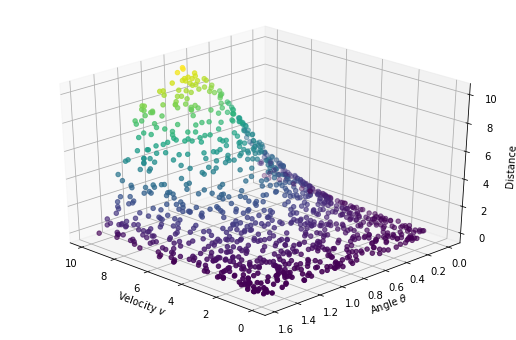

In [ ]:
#@title #### Figure: Data

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

plot_data(vs, thetas, distances, ax=ax)

### 1. A Model-less Approach

The simplest approach to the problem is to not have a model at all - the data is the model!
In this approach they pick the closest historical data they have to the data they want to predict and use the output of the historical data as their prediction, i.e.
$$ F(v,\theta) = s_{i^*} \quad \text{ where }  \quad i^* = \textrm{argmin}_{i} \{\textrm{Dist}((v,\theta), (v_i,\theta_i)) \}$$
where $\textrm{Dist}(\cdot, \cdot)$ is a distance function such as the L2-norm.


In [ ]:
# A model-less approach: find the closest data point we have an return the 
# resulting output.

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

# Give a prediction for the point (4.0,1.2)
ix = closest_node([4,1.2], x_train)
x_train[ix,:], y_train[ix]

(tensor([3.9268, 1.2042]), tensor([1.0437]))

This purely-data driven approach has an obvious draw-back.
If their data does not cover the range of possible inputs, or the data is sparse, then they can run into issues.
Here, without a model they cannot accurately predict what would happen if they considered velocities greater than $v=10$ for example.

In [ ]:
# Give a prediction for the point (20.0,0.85)
ix = closest_node([20,0.85], x_train)
x_train[ix,:], y_train[ix]

(tensor([9.9885, 1.1096]), tensor([8.1159]))

Despite this drawn-back, the model-less approach does see use in industry, in particular to address the [cold start problem](https://en.wikipedia.org/wiki/Cold_start_(computing).
For example, recommendation systems (e.g. video recommendation on Netflix, product recommendations at Amazon) can be incredibly powerful tools to learn your preferences however these rely on having at least some information about your preferences.
For new customers this information is not present.
One approach therefore is to take whatever information is present (e.g. age, location, gender) and match initial predictions to those of an existing customer.

### 2. A Linear Model Approach

Looking at the data it is clear that their function is non-linear, and a linear model is unlikely to be accurate.
It can however sometimes be difficult to visualise the *shape* of data, or such analysis is omitted altogether!
Linear models are not without merit and are fundamental to many applications, and so they decide to try using one.

The linear model is described by
$$ F(v, \theta) = w_1v + w_2\theta +b $$
where $w_i\in \mathbb{R}$ are weights and $b\in \mathbb{R}$ is a bias term, all to be determined.
For continuity they implement the linear model in PyTorch and find the model parameters using stochastic gradient descent (there are of course cleverer and simpler methods).

In [ ]:
# A simple linear regression model implemented in PyTorch.
class LinearRegressor(nn.Module):
        
    def __init__(self, input_dim, output_dim):
        """ A two layer network mapping input directly to output. """
        
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)
    
    def get_parameters(self):
        """ Returns the model weights and bias. """
        w, b = self.parameters() 
        return w.data, b.data

In [ ]:
# Initialise the model, assign a loss function, and optimiser.
model = LinearRegressor(2,1) 
criterion = nn.MSELoss() 
optimizer = optim.SGD(model.parameters(), lr = 0.01) 

In [ ]:
# Run the model 
num_epochs = 500
for epoch in range(num_epochs): 

	# Forward pass: Compute predicted y by passing x to the model 
    pred_y = model.forward(x_train) 

    # Compute loss 
    loss = criterion(pred_y, y_train) 

    # Zero gradients, perform a backward pass, 
    # and update model weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    
    if (epoch+1) % 100 == 0:
        print('Epoch[{}/{}], Loss: {:.6f}'.format(epoch+1, num_epochs, loss.data))

Epoch[100/500], loss: 2.426076
Epoch[200/500], loss: 2.393808
Epoch[300/500], loss: 2.389446
Epoch[400/500], loss: 2.388700
Epoch[500/500], loss: 2.388478


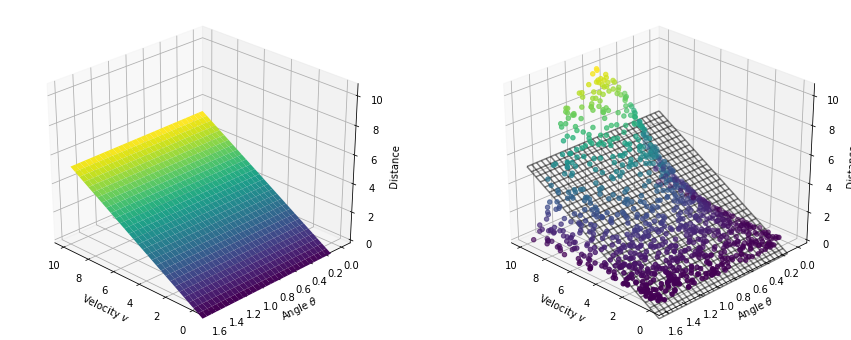

In [ ]:
#@title #### Figure: Linear Model

w, b = model.get_parameters()
w = w.numpy()
b = b.numpy()

v = np.linspace(x_train[:,0].min(), x_train[:,0].max(), 30)
theta = np.linspace(x_train[:,1].min(), x_train[:,1].max(), 30)

V, T = np.meshgrid(v,theta)

d = w[0][0]*V + w[0][1]*T + b[0]

plot_model_comparison(vs, thetas, distances, V, T, d)

As expected, the linear model fails to capture both the non-monotonicity in the $\theta$-direction, and the quadratic grow in the $v$-direction.


### 3. The Black-box Approach - Deep neural networks

Having invested heavily in machine learning research and computational frameworks, the scientists are keen to throw the metaphorical kitchen sink at the problem, in the form of a deep neural network.
Specifically they utilise a [multilayer perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron) which consists of number of linear layers with a non-linear activation interspersed between.
The model can be described by
$$ \textrm{Linear}(2,256) \to \textrm{Sigmoid} \to \textrm{Linear}(256,256) \to \textrm{Sigmoid} \to \textrm{Linear}(256,1) $$
where the arguments represent the number of variables each model takes, i.e. two inputs and one output.
There are many natural questions to ask here - how deep or wide does the network need to be and which activation functions should be used?
Furthermore how quickly does this network train and does it approach a global optimal solution?
These questions form a significant part of current research in machine learning, and fortunately [some of them have answers](https://en.wikipedia.org/wiki/Universal_approximation_theorem).



In [ ]:
# "Black Box" Neural Network, or MultiLayer Perceptron (MLP)
class Blackbox(nn.Module):
    
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)   
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   
        self.predict = torch.nn.Linear(n_hidden, n_output) 

    def forward(self, x):
        x = torch.sigmoid(self.hidden1(x))      
        x = torch.sigmoid(self.hidden2(x))
        x = self.predict(x)
        return x

In [ ]:
x_train = torch.from_numpy(np.hstack([vs,thetas]).astype(np.float32))
y_train = torch.from_numpy(distances.astype(np.float32))

# Initialise the model, loss function, and optimiser (Adam).
model = Blackbox(n_feature=2, n_hidden=256, n_output=1) 
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Use a GPU if available to speed up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))
model = model.to(device)

Using cuda


In [ ]:
# Train the model
num_epochs = 1000
losses = []
for epoch in range(num_epochs): 

    # Forward pass
    pred_y = model.forward(x_train.to(device)) 

    # Compute loss 
    loss = criterion(pred_y, y_train.to(device))

    # Zero gradients, perform a backward pass, 
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 

    if (epoch+1) % 200 == 0:
        losses.append(loss.data)
        print('Epoch[{}/{}], Loss: {:.6f}, Max Gradient: {:.6f}'
              .format(epoch+1, num_epochs, loss.data, max([(-x.data).max() for x in model.parameters()])))

Epoch[200/1000], Loss: 0.111930, Max Gradient: 2.746020793914795
Epoch[400/1000], Loss: 0.032923, Max Gradient: 2.7668488025665283
Epoch[600/1000], Loss: 0.008271, Max Gradient: 2.79529070854187
Epoch[800/1000], Loss: 0.002359, Max Gradient: 2.824122190475464
Epoch[1000/1000], Loss: 0.001108, Max Gradient: 2.8465383052825928


The model is again trained using an adaptive optimiser called Adam, giving the function below.

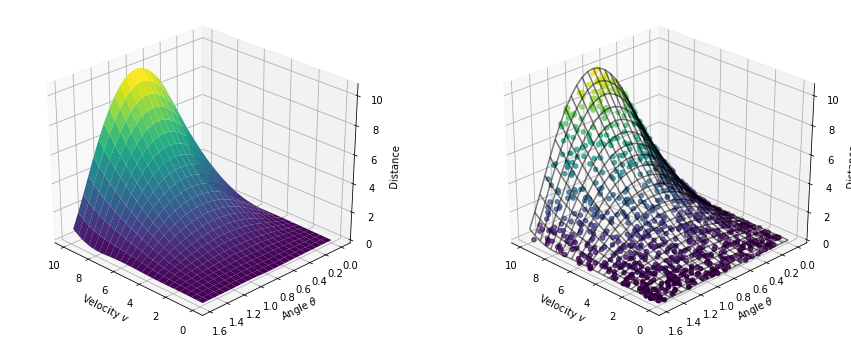

In [ ]:
#@title #### Figure: Black-box Prediction

model = model.to('cpu')

v = np.linspace(0, 10, 25)
theta = np.linspace(0, np.pi/2, 25)

V, T = np.meshgrid(v,theta)
V = V.reshape(-1,1)
T = T.reshape(-1,1)
X = torch.from_numpy(np.hstack([V,T]).astype(np.float32)) 

d = model(X).detach().numpy().reshape(25,25)

plot_model_comparison(vs, thetas, distances, V.reshape(25,25), T.reshape(25,25), d)



For the uninitiated it might be surprising how well the neural network approximates the given data.
This has predominantly been the story of deep learning so far - it works, and can work extremely well, but we are not always sure why.


### 4. The Quasi-linear Approach - Learning a mathematical expression

In the black-box model the scientists have a model that can accurately predict how far the cannon is going to fire, however as the name suggests, they have no intuition to the form of the function.
The scientists are keen to get this intuition back while still using a machine learning approach and resort back to using a linear model.

Having studied trigonometry in their school days, the scientists are convinced that the solution to the problem will likely involve some trigonometric functions of the angle composed with a function of the velocity.
They propose to write the model as
$$ F(v,\theta) = w_1 v + w_2 v^2 + w_3 v\sin(\theta) + w_4 v\sin(2\theta) + w_5 v^2 \sin(\theta) + w_6 v^2 \sin(2\theta),$$
a linear combination of non-linear [basis functions](https://en.wikipedia.org/wiki/Basis_function).

In [ ]:
# Linear regression using a set of basis functions.

class BasisRegressor(nn.Module):
    """Approximates a set of points by a set of basis functions."""
        
    def __init__(self, basis):
        super(BasisRegressor, self).__init__()
        self.basis = basis
        self.weights = nn.Parameter(torch.Tensor(len(basis)))
        self.weights.data = torch.from_numpy(np.random.random(len(basis))[:np.newaxis].astype(np.float32))
        
    def forward(self, x):
        prediction = torch.stack([w*f(x[:,0],x[:,1]) for w,f in zip(self.weights,self.basis)])
        prediction = torch.sum(prediction, dim=0)
        return prediction.unsqueeze(1)
    
    def get_parameters(self):
        weights, = self.parameters() 
        return weights.data

In [ ]:
# Initialise the model using basis function list
# Set the loss function and optimiser.
basis_functions = [lambda x,y: x,
                   lambda x,y: x**2,
                   lambda x,y: x*np.sin(y),
                   lambda x,y: x*np.sin(2*y),
                   lambda x,y: (x**2)*np.sin(y),
                   lambda x,y: (x**2)*np.sin(2*y)]

model = BasisRegressor(basis_functions) 
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(),lr=0.1)

In [ ]:
num_epochs = 5000
for epoch in range(num_epochs): 

	# Forward pass: Compute predicted y by passing x to the model 
    pred_y = model.forward(x_train) 

    # Compute loss 
    loss = criterion(pred_y, y_train) 

    # Zero gradients, perform a backward pass, 
    # and update the weights. 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    
    if (epoch+1) % 1000 == 0:
        print('Epoch[{}/{}], Loss: {:.6f}, Max Gradient: {:.6f}'
              .format(epoch+1, num_epochs, loss.data, model.weights.grad.max()))

Epoch[1000/5000], Loss: 0.010195, Max Gradient: 0.054714
Epoch[2000/5000], Loss: 0.000980, Max Gradient: 0.016267
Epoch[3000/5000], Loss: 0.000102, Max Gradient: 0.001818
Epoch[4000/5000], Loss: 0.000091, Max Gradient: 0.000026
Epoch[5000/5000], Loss: 0.000091, Max Gradient: 0.000034


Since the non-linearity is embedded into a linear model, they can calculate the parameters just as they did in the linear model. Upon optimising they arrive at the model:

In [ ]:
#@title #### Learned Equation
weights = model.weights.data.numpy()
from IPython.display import Markdown, display, Latex, HTML, Math

display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
             "latest.js?config=default'></script>"))
display(Math(r"x^* = {:.2f}v + {:.2f}v^2 + {:.2f}v\sin(\theta) + {:.2f}v\sin(2\theta) + {:.2f}v^2\sin(\theta) + {:.2f}v^2\sin(2\theta)".format(*weights)))

<IPython.core.display.Math object>

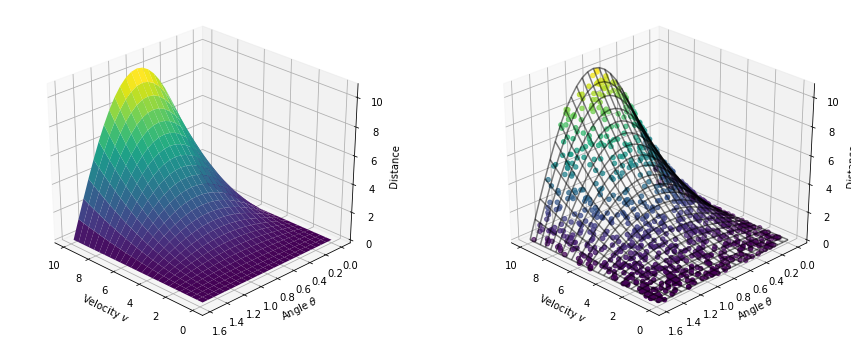

In [ ]:
#@title #### Figure: Machine-Learned Equation

v = np.linspace(0, 10, 25)
theta = np.linspace(0, np.pi/2, 25)

V, T = np.meshgrid(v,theta)

V = V.reshape(-1,1)
T = T.reshape(-1,1)
X = torch.from_numpy(np.hstack([V,T]).astype(np.float32)) 

d = model(X).detach().numpy().reshape(25,25)

plot_model_comparison(vs,thetas,distances, V.reshape(25,25),T.reshape(25,25),d)

In this case the optimisation has zeroed all parameters with the exception of one leaving the model as $F(v,\theta) = 0.102v^2\sin(2\theta)$.
Comparing $F$ to the data they see that the model is predictive including the gradients at the data boundaries.
They also have the added bonus that they have a compact and explicit formula for the model!
Arguably in this case they have been quite lucky (or sneaky) with the choice of basis functions however there is nothing to stop them from adding more functions to the list except that it increases the number of parameters needed to be fitted.

### 5. The Mathematical Approach - A data-less model

Years pass and eventually calculus is invented/discovered, depending on which side of the fence you lie on.
The two scientists revisit the problem, this time having lost their previous data.
Now armed with the power of integration they attempt to solve the problem again.


#### A. Setting up Equations

The physical model of low speed projectiles is quite simple.
Projectiles accelerate downwards towards the planet, and this acceleration is constant, say $-g$.
With no forces acting on the projectile in the $x$-direction it maintains its initial velocity perpetually.
The model can be written as the system of second order differential equations
$$
\begin{align}
\ddot{x} &= 0 \\
\ddot{y} &= -g
\end{align}
$$
with the initial conditions given by
$$
\begin{align}
x(0) &= 0 \\
y(0) &= 0 \\
\dot{x}(0) &= v\cos\theta \\
\dot{y}(0) &= v\sin\theta. \\  
\end{align}
$$
The latter two equations describe the horizontal and vertical components of the velocity when the cannon is initially fired.
These equations describe the system, but how do they solve them?

#### B. Numerical Integration

Quite often in mathematics, writing down the differential equations is the simple part - most of the time is spent trying to solve them!

They describe the model instead by system of first-order ordinary differential equations (ODEs) by considering the system
$$
\begin{align}
    \dot{x} &= a \\
    \dot{a} &= 0 \\
    \dot{y} &= b \\
    \dot{b} &= -g
\end{align}
$$
with initial conditions
$$
\begin{align}
x(0) &= 0 \\
y(0) &= 0 \\
a(0) &= v\cos\theta \\
b(0) &= v\sin\theta \\  
\end{align}
$$
It is easily to verify that these two representations are equivalent.

Since the need for integration is ubiquitous in mathematics, a number of methods have been developed to integrate numerically.
The simplest and most intuitive method is the [Euler method](https://en.wikipedia.org/wiki/Euler_method) which involves starting at an initial point and taking small steps in the direction of the gradient at that point, i.e.
$$ w(t_0)= w_0 \quad \text{ with} \quad w_{n+1} = w_n + \eta (\partial_t w)(t_n) $$

Using numerical integration they can accurately predict the *entire trajectory* of the projectile, not just where it would land.

**Note:** The code below is interactive on the collaboratory version.


In [ ]:
#@title #### Numerical Integration

from scipy.integrate import odeint

def f(z,t,g):
    return [z[1], 0, z[3], -g]

#@markdown Cannon velocity
v = 14 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Cannon angle (degrees)
theta = 59 #@param {type:"slider", min:0, max:90, step:1}
theta = theta*(np.pi/2)/90

z0 = [0,v*np.cos(theta), 0, v*np.sin(theta)]
t = np.linspace(0,2*v*np.sin(theta)/g,1000)
x, a, y, b = odeint(f, z0, t, args=(g,)).T

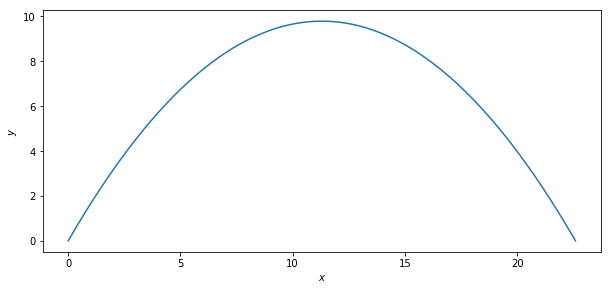

In [ ]:
#@title #### Figure: Numerical Integration

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(x,y);

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');


The location of the landing spot is $x(t^*)$ such that $y(t^*)=0$, which they can extract from the predicted trajectory.


In [ ]:
# Find the time at which y is closest to 0
idx = (np.abs(y[1:])).argmin()
# Find the corresponding x-value
x[idx+1],y[idx+1]

(22.599643564609202, -1.1723955140041653e-12)


The bonus of the fully defined model is that they can test new initial conditions that they haven't seen experimentally - such as having an uneven landscape, or firing the cannon from a tower or raised platform ($y(0) \neq 0$).

#### C. Analytical Solution

Finally the two scientists learn how to integrate, and it turns out the problem is not so difficult after all.
The equations for $x$ and $y$ can be solved independently.
Solving each equation (and applying initial conditions) gives

$$x(t) = At + B \\
x(0)=0 \implies B = 0 \\
\dot{x}(0)=v\cos\theta \implies A = v\cos\theta
$$
and hence
$$x(t) = v t\cos\theta.$$
Similarly
$$\dot{y} = -gt + C \\
y(t) = -\frac{1}{2}gt^2 + Ct + D \\
y(0) = 0 \implies  D=0 \\
\dot{y}(0) = v\sin\theta \implies C = v\sin\theta \\
$$ 
and so
$$y(t) = -\frac{1}{2}gt^2 + vt\sin\theta$$ 

These give them the $x$ and $y$ coordinates as functions of time, but when does the projectile hit the ground?
This happens when $y=0$, i.e.,

$$y(t) = 0 = -\frac{1}{2}gt^2 + vt\sin\theta \\
t(v\sin\theta - \frac{1}{2}gt) = 0$$
This has solutions $t^* = 0$ (before the cannon is fired), and $t^* = \frac{2v\sin\theta}{g}$ (when it hits the ground).
They plug this second value of $t^*$ in to their equation for $x$ to get the final distance travelled, which is equal to
$$x\left(\frac{2v\sin\theta}{g}\right) = \frac{2v^2\sin\theta\cos\theta}{g} = \frac{ v^2 \sin 2\theta}{g}.$$

Their final predictive model is then
$$ F(v, \theta) = \frac{ v^2 \sin 2\theta}{g}.$$
They find that this agrees nicely with the quasi-linear approach which also gave them an estimate for the gravitational constant.

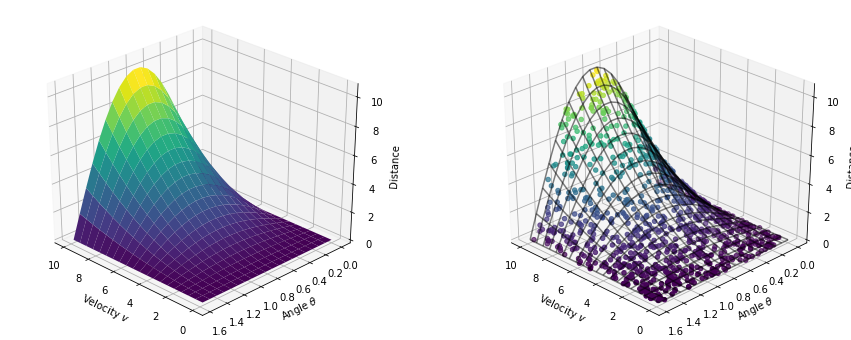

In [ ]:
#@title #### Figure: Analytical Solution
v = np.linspace(0, 10, 20)
theta = np.linspace(0, np.pi/2, 20)

V, T = np.meshgrid(v,theta)

def analytical_distance(v,theta,g):
    return (v**2)*np.sin(2*theta)/g

d = analytical_distance(V,T,g)


plot_model_comparison(vs,thetas,distances, V,T,d)

### 6. The Neural ODE Approach - Learning the dynamical system

As a bonus approach (...they are showing off at this point) they consider the scenario where they don't know the physical model (they have no theory of gravity).
They have a system of ODEs as before
$$ dx_t  = f_1(x,y,t) \\
   dy_t = f_2(x,y,t)$$
except that $f_1$ and $f_2$ are unknown (here omitting the dummy variables for brevity).

A [recent paper from NIPS](https://papers.nips.cc/paper/7892-neural-ordinary-differential-equations) presented a method to learn a system of ODEs given only a trajectory of a projectile. 
In short, it does this by replacing $f_1,f_2$ by a neural network and numerically integrating the neural network to get the trajectory.
Learning can be carried out as normal since the numerical integration methods have well defined gradients.
In their example, if the scientists could track the position of the cannonball over time, data $(x_i,y_i,t_i)$ say, then they could in principle recover the physical model and learn that objects fall with constant acceleration.
This is an exciting new application of deep learning which opens up the possibility of learning why systems behave as they do, rather than learning simply their output.

**Note:** Neural ODEs have many more interesting features which I will be cover in a subsequent post - watch this space!

## What Have We Learned?

We live in a fortunate time where we can solve even a simple problem hundreds of different ways.
Our approaches above are by no means an exhaustive list - we can also consider simulation approaches, data assimilation, or algebraic approaches.
Furthermore, at any time where we have 'optimised' to find parameters or a neural network above we could equivalently replace the neural network with *any* parameterised model, and *any* of the many ways perform optimisation.
This leaves us with a zoo of possibilities and modelling choices, each with particular data requirements, computational cost, accuracy, or extendability.
So while it may be unsatisfactory that we don't have a unified "model solver," it goes to show that there may never be one.
This highlights the role of machine learning in mathematics - one of many powerful tools we can use to understand our world and make predictions.
Where simulations are currently used as validation, perhaps we should add a machine-learned model to the mix as well?

Mathematicians take comfort in the fact that mathematical models are explainable, and hopefully, intuitive.
Applied without consideration, deep learning models are exactly the opposite.
In the examples we have seen here, we have seen that constructing a mathematical model and filling in the gaps with machine learning can lead to both better accuracy and faster computation.
If we can bake in as much physical theory as we can, and use machine learning to plug the gaps in our knowledge then we stand a chance at tackling more complex problems.
Typically machine learning is used for parameter fitting, but in a hybrid model we could fit entire functions which form part of the larger system.
I believe we will see many of these hybrid models in the future as both theory and technology improves and so our future will be *collaborative* rather than *competitive*.

Although we haven't mentioned explicitly, the quality, quantity, and type of data will have a significant effect on the approach you take.
Is the data noisy or erroneous, what shape does it take, and does it sufficiently sample the range of all possibilities.
Should you decide to take a data-driven approach, understanding your data should be the first priority, as we have seen in this simple example that a little knowledge goes a long way to creating an accurate and informative model.

Finally, as a counter to the hype of how machine learning methods perform unreasonably well I recently came across the article [The Unreasonable Effectiveness of Mathematics. *E. Wigner* (1960)](https://en.wikipedia.org/wiki/The_Unreasonable_Effectiveness_of_Mathematics_in_the_Natural_Sciences) which shows that we too as mathematicians are wielding powerful tools which we don't fully understand.
